### The goal of this notebook is to create a multifaceted boxplot to describe the American Gut Cohort

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
from statannot import add_stat_annotation
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
import statsmodels.api as sm
import statsmodels.formula.api as smf


### Load american gut metadata and filter

In [2]:
# Get cdiff metadata, filter, and merge with cdiff alpha diversity data
metadata = pd.read_csv('.../american_gut/metadata.tsv', sep = '\t', low_memory = False)
cdiff=pd.read_csv('.../american_gut_cohort/simpson/data/alpha-diversity.tsv', sep = '\t')
cdiff=cdiff.rename(columns = {'Unnamed: 0':'sample_name'})
cdiff=pd.merge(metadata, cdiff, on ='sample_name', how = 'left')

#Converting values to numeric
cdiff['height_cm'] = pd.to_numeric(cdiff['height_cm'], errors = 'coerce')
cdiff['weight_kg'] = pd.to_numeric(cdiff['weight_kg'], errors='coerce')
cdiff['age_years'] =  pd.to_numeric(cdiff['age_years'], errors='coerce')

#Filtering to only include adults, feasible heights, and average weights
cdiff=cdiff[cdiff['age_years'] >= 18].rename(columns = {'age_years':'age'})
cdiff=cdiff[(cdiff['height_cm'] <= 244) & (cdiff['height_cm'] >= 122)]
cdiff=cdiff[cdiff['weight_kg']<300]

cdiff=cdiff.reset_index(drop=True)
# # Convert BMF to numeric for regressions
norm_bmf=list()
for i in range(0,len(cdiff)):
    check = cdiff.loc[i,'bowel_movement_frequency']
    if check == 'Less than one':
        norm_bmf.append(1) #put it between one and two to match arivale df
    elif check == 'One':
        norm_bmf.append(2)
    elif check == 'Two':
        norm_bmf.append(2)
    elif check == 'Three':
        norm_bmf.append(3)
    elif check == 'Four':
        norm_bmf.append(4)
    elif check=='Five or more':
        norm_bmf.append(4)
    else:
        norm_bmf.append(float('nan'))
        
cdiff['bowel_movement_frequency']=norm_bmf

# Convert simpson to simpson 1/D
cdiff['simpson']=cdiff['simpson'].apply(lambda x:1/(1-x))

# Convert height from cm to inches so I can calculate the BMI 
cdiff['height_in']=cdiff['height_cm'].apply(lambda x: x/2.54)
cdiff['weight_lb']=cdiff['weight_kg'].apply(lambda x: x*2.205)
cdiff['BMI_CALC']= cdiff['weight_lb']/(cdiff['height_in']**2)*703

# Convert sex info to just M and F
binary_sexes=['female', 'male']
cdiff=cdiff[cdiff['sex'].isin(binary_sexes)]
cdiff['sex']=cdiff['sex'].apply(lambda x: 'F' if x=='female' else 'M')

cdiff.head()

,sample_name,acid_reflux,acne_medication,acne_medication_otc,add_adhd,age_cat,age_corrected,age,alcohol_consumption,alcohol_frequency,...,vivid_dreams,weight_change,weight_kg,weight_units,whole_eggs,whole_grain_frequency,simpson,height_in,weight_lb,BMI_CALC
0,10317.000001000,Not provided,false,false,"Diagnosed by a medical professional (doctor, p...",60s,64.0,64.0,true,Daily,...,Not provided,Remained stable,52.0,kilograms,Never,Occasionally (1-2 times/week),5.923093,60.629921,114.66,21.927709
1,10317.000001001,Not provided,false,false,Not provided,50s,53.0,53.0,true,Rarely (a few times/month),...,Not provided,Remained stable,110.0,kilograms,Not provided,Not provided,6.189050,68.897638,242.55,35.920960
2,10317.000001002,Not provided,false,false,Not provided,50s,53.0,53.0,true,Regularly (3-5 times/week),...,Not provided,Not provided,56.0,kilograms,Not provided,Not provided,9.462242,66.141732,123.48,19.842702
3,10317.000001004,Not provided,false,false,Not provided,40s,44.0,44.0,true,Rarely (a few times/month),...,Not provided,Remained stable,86.0,kilograms,Not provided,Not provided,16.204136,61.811024,189.63,34.892372
4,10317.000001008,Not provided,false,false,Not provided,60s,66.0,66.0,false,Never,...,Not provided,Increased more than 10 pounds,74.0,kilograms,Not provided,Not provided,5.503272,61.811024,163.17,30.023669


### Create a new column that states whether the individual has been diagnosed with cdiff and categorize individuals into high and low vegetable consumption

In [3]:
# Define which responses will be a 'yes' or 'no' diagnosis
keep = ['I do not have this condition', \
        'Diagnosed by a medical professional (doctor, physician assistant)']

# just get samples where I know whether they have been diagnosed or not
cdiff = cdiff[cdiff['cdiff'].isin(keep)] 

# Make a new column for yes if diagnosed and no if not
cdiff['diagnosis'] = cdiff['cdiff'].apply(lambda x: 'yes' if x=='Diagnosed by a medical professional (doctor, physician assistant)' 
                                          else 'no')

#Filter (make new df since I'm going to lose samples for vegetable consumption responses
veggies=cdiff.copy()
veggies=veggies[veggies['vegetable_frequency']!= 'Not provided']

# Define high and low vegetable_consumption
veggies['vegetable_consumption'] = veggies.vegetable_frequency.apply(lambda x: 'high' if x =='Daily' else 'low')

### Create my boxplots

In [4]:
veggies.head()

,sample_name,acid_reflux,acne_medication,acne_medication_otc,add_adhd,age_cat,age_corrected,age,alcohol_consumption,alcohol_frequency,...,weight_kg,weight_units,whole_eggs,whole_grain_frequency,simpson,height_in,weight_lb,BMI_CALC,diagnosis,vegetable_consumption
0,10317.000001000,Not provided,false,false,"Diagnosed by a medical professional (doctor, p...",60s,64.0,64.0,true,Daily,...,52.0,kilograms,Never,Occasionally (1-2 times/week),5.923093,60.629921,114.660,21.927709,no,high
11,10317.000001031,Not provided,false,false,I do not have this condition,60s,64.0,64.0,true,Rarely (a few times/month),...,56.0,kilograms,Occasionally (1-2 times/week),Never,5.730412,70.078740,123.480,17.675812,no,low
14,10317.000001040,Not provided,false,false,I do not have this condition,70+,70.0,70.0,false,Never,...,86.0,kilograms,Occasionally (1-2 times/week),Rarely (less than once/week),NaN,61.811024,189.630,34.892372,no,low
15,10317.000001041,Not provided,false,false,I do not have this condition,50s,59.0,59.0,true,Regularly (3-5 times/week),...,61.0,kilograms,Regularly (3-5 times/week),Occasionally (1-2 times/week),7.213558,63.779528,134.505,23.245086,no,high
59,10317.000001166,I do not have this condition,false,false,I do not have this condition,40s,47.0,47.0,true,Regularly (3-5 times/week),...,74.0,kilograms,Never,Occasionally (1-2 times/week),11.360332,67.716535,163.170,25.015327,no,low


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

no v.s. yes: t-test independent samples, P_val=9.394e-05 stat=3.909e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

no v.s. yes: t-test independent samples, P_val=1.832e-03 stat=3.119e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

no v.s. yes: t-test independent samples, P_val=2.800e-02 stat=2.198e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

no v.s. yes: t-test independent samples, P_val=1.864e-05 stat=4.283e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00


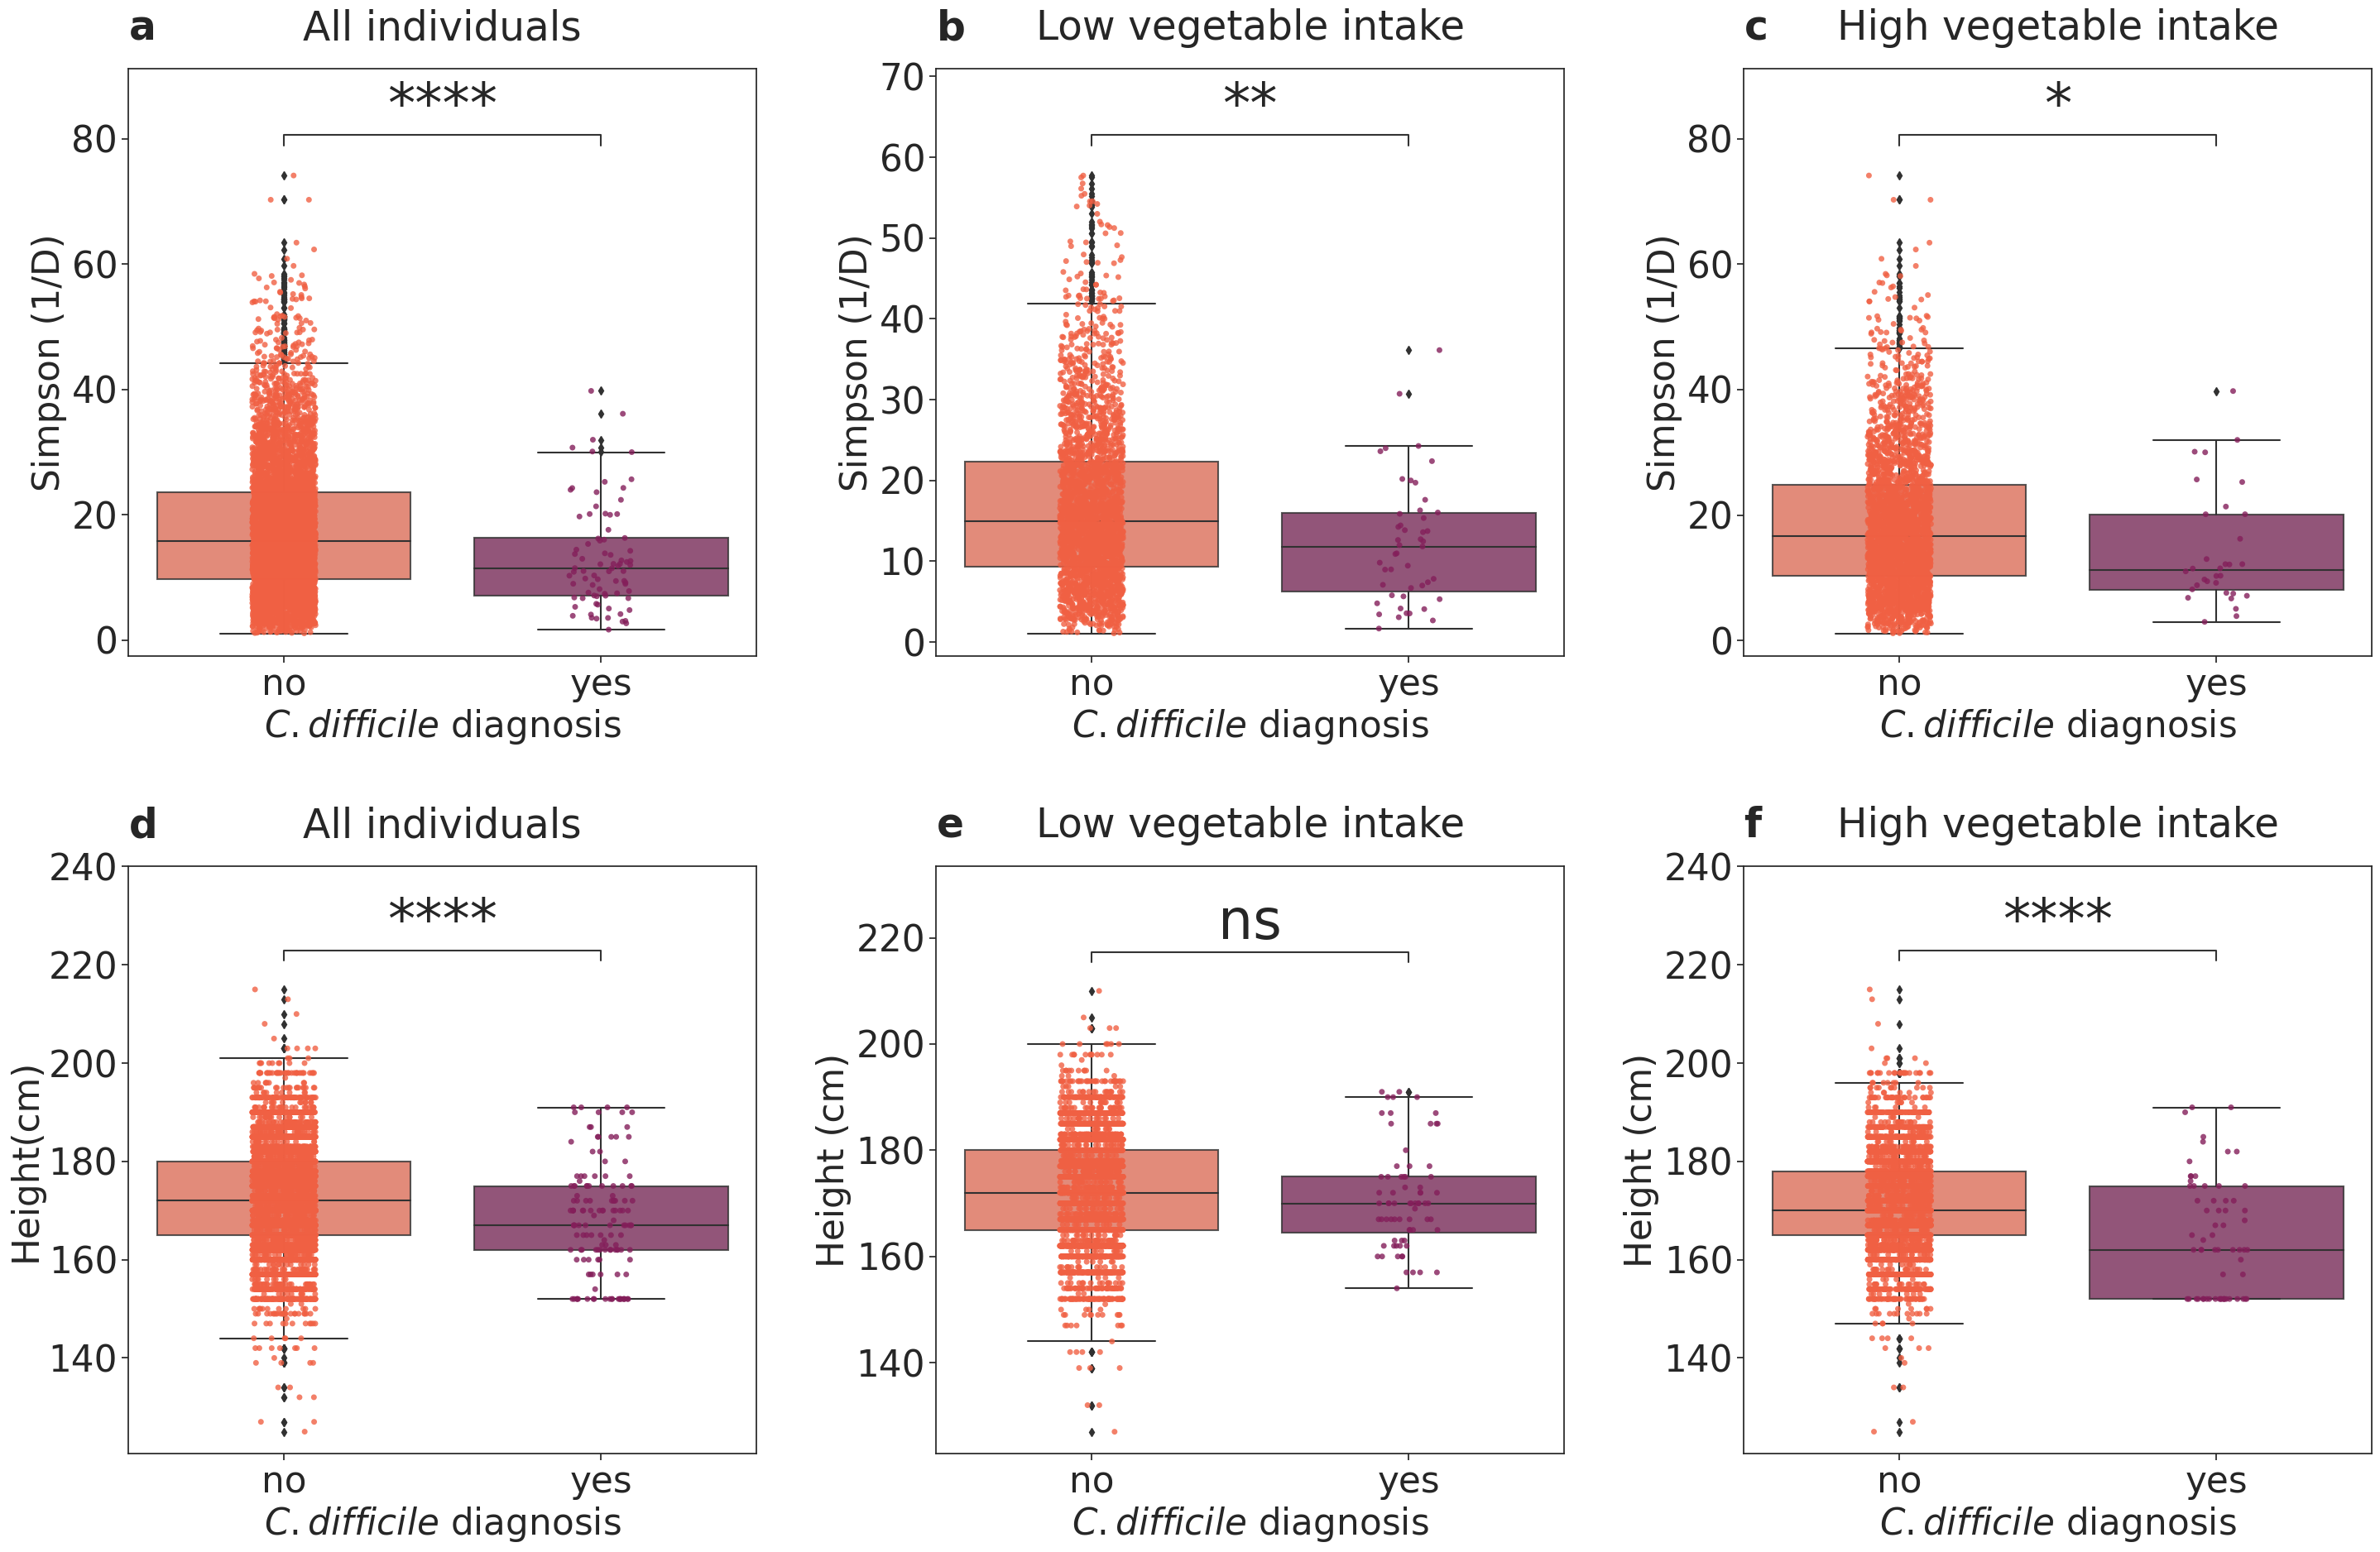

In [17]:
fig, axs = plt.subplots(2,3,figsize=(30,20), tight_layout=True)
sns.set_theme(style='ticks', font_scale=4)

size = 35
params= {'axes.labelsize':size*0.9,
         'axes.titlesize':size, 
         'xtick.labelsize':size*0.9,
         'ytick.labelsize':size*0.9, 
         'axes.titlepad':25, 
         'patch.force_edgecolor': True}

plt.rcParams.update(params)

axs[0,0].set_title('a', loc='left', fontweight='bold', fontsize=size)
axs[0,1].set_title('b', loc='left', fontweight='bold', fontsize=size)
axs[0,2].set_title('c', loc='left', fontweight='bold', fontsize=size)
axs[1,0].set_title('d', loc='left', fontweight='bold', fontsize=size)
axs[1,1].set_title('e', loc='left', fontweight='bold', fontsize=size)
axs[1,2].set_title('f', loc='left', fontweight='bold', fontsize=size)

x = 'diagnosis'
y = 'simpson'

axs[0,0] = sns.boxplot(data = cdiff, x = x, y = y, ax=axs[0,0], palette='rocket_r', boxprops=dict(alpha=0.8))
axs[0,0]=sns.stripplot(data=cdiff, x=x, y=y, ax=axs[0,0], palette='rocket_r', alpha=0.8)

axs[0,0].set(xlabel='$C. difficile$ diagnosis', ylabel='Simpson (1/D)', title='All individuals')
axs[0,0] = add_stat_annotation(
    axs[0,0], data = veggies, x = x, y = y,
    box_pairs = [('yes', 'no')],
    test = 't-test_ind',
    comparisons_correction=None,
    text_format = 'star', 
    loc = 'inside', verbose = 2
)
                         
axs[0,1] = sns.boxplot(data = veggies[veggies['vegetable_consumption']=='low'], x=x, y=y, palette='rocket_r', ax=axs[0,1],boxprops=dict(alpha=0.8))
axs[0,1] = sns.stripplot(data=veggies[veggies['vegetable_consumption']=='low'], x=x, y=y, palette='rocket_r', ax=axs[0,1], alpha = 0.8)

axs[0,1].set(xlabel = '$C. difficile$ diagnosis', ylabel = 'Simpson (1/D)', title='Low vegetable intake')
axs[0,1] = add_stat_annotation(
    ax=axs[0,1], data = veggies[veggies['vegetable_consumption']=='low'], x=x, y=y,
    box_pairs = [('yes', 'no')], 
    test = 't-test_ind',
    comparisons_correction=None,
    text_format = 'star', 
    loc = 'inside', verbose = 2
)

axs[0,2] = sns.boxplot(ax=axs[0,2],data=veggies[veggies['vegetable_consumption']=='high'], x=x, y=y, palette='rocket_r', boxprops=dict(alpha=0.8))
axs[0,2] = sns.stripplot(ax=axs[0,2], data=veggies[veggies['vegetable_consumption']=='high'], x=x, y=y, palette='rocket_r', alpha = 0.8)

axs[0,2].set(xlabel = '$C. difficile$ diagnosis', ylabel = 'Simpson (1/D)', title='High vegetable intake')
axs[0,2]=add_stat_annotation(
    ax=axs[0,2], data=veggies[veggies['vegetable_consumption']=='high'], x=x, y=y,
    box_pairs= [('yes', 'no')], 
    test = 't-test_ind',
    comparisons_correction=None,
    text_format = 'star', 
    loc = 'inside', verbose = 2
)

x = 'diagnosis'
y = 'height_cm'

axs[1,0] = sns.boxplot(data =cdiff, x=x, y=y, ax=axs[1,0], palette='rocket_r', boxprops=dict(alpha=0.8))
axs[1,0] = sns.stripplot(data=cdiff, x=x, y=y, ax=axs[1,0], palette='rocket_r', alpha = 0.8)

axs[1,0].set(xlabel='$C. difficile$ diagnosis', ylabel='Height(cm)', title='All individuals')
axs[1,0] = add_stat_annotation(
    axs[1,0], data = cdiff, x = x, y = y,
    box_pairs = [('yes', 'no')],
    test = 't-test_ind',
    comparisons_correction=None,
    text_format = 'star',
    loc = 'inside', verbose = 2
)
                         
axs[1,1] = sns.boxplot(data = veggies[veggies['vegetable_consumption']=='low'], x=x, y=y, palette='rocket_r', ax=axs[1,1], boxprops=dict(alpha=0.8))
axs[1,1] = sns.stripplot(data=veggies[veggies['vegetable_consumption']=='low'], x=x, y=y, palette='rocket_r', ax=axs[1,1], alpha=0.8)


axs[1,1].set(xlabel = '$C. difficile$ diagnosis', ylabel = 'Height (cm)', title='Low vegetable intake')
axs[1,1] = add_stat_annotation(
    ax=axs[1,1], data = veggies[veggies['vegetable_consumption']=='low'], x=x, y=y,
    box_pairs = [('yes', 'no')], 
    test = 't-test_ind',
    comparisons_correction=None,
    text_format = 'star', 
    loc = 'inside', verbose = 2
)

axs[1,2] = sns.boxplot(ax=axs[1,2],data=veggies[veggies['vegetable_consumption']=='high'], x=x, y=y, palette='rocket_r', boxprops=dict(alpha=0.8))
axs[1,2] = sns.stripplot(ax=axs[1,2], data=veggies[veggies['vegetable_consumption']=='high'], x=x, y=y, palette='rocket_r', alpha=0.8)

axs[1,2].set(xlabel = '$C. difficile$ diagnosis', ylabel = 'Height (cm)', title='High vegetable intake')
axs[1,2]=add_stat_annotation(
    ax=axs[1,2], data=veggies[veggies['vegetable_consumption']=='high'], x=x, y=y,
    box_pairs= [('yes', 'no')], 
    test = 't-test_ind',
    comparisons_correction=None,
    text_format = 'star', 
    loc = 'inside', verbose = 2
)


In [6]:
fig.savefig('.../output/cdiff_boxplots.png', bbox_inches='tight')

### Clean up data for regressions

In [7]:
# Make new df for regressions
data=veggies.copy()
data=data[['diagnosis', 'height_cm', 'age', 'sex', 'BMI_CALC', 'vegetable_consumption', 'simpson', 'bowel_movement_frequency']].dropna().reset_index(drop=True)

## Standardize data
features=['height_cm', 'age', 'BMI_CALC', 'simpson']
data[features]=data[features].apply(lambda x: (x - x.mean()) / x.std())

# Make CDI history and veggie consumption binomial 
data=data.sort_values(by='vegetable_consumption', ascending=True)
data['has_cdiff']=data['diagnosis'].apply(lambda x: 1 if x=='yes' else 0)
data['high_vegetable_consumption']=data['vegetable_consumption'].apply(lambda x: 1 if x=='high' else 0)
data
data.head()

,diagnosis,height_cm,age,sex,BMI_CALC,vegetable_consumption,simpson,bowel_movement_frequency,has_cdiff,high_vegetable_consumption
0,no,-1.762137,1.052606,F,-0.487131,high,-1.112092,2.0,0,1
3032,no,-0.951492,0.650427,F,1.185864,high,-0.555755,2.0,0,1
3035,no,1.581772,0.248247,M,2.550256,high,0.250727,2.0,0,1
3038,no,-0.951492,1.186666,F,-0.527577,high,-0.472701,2.0,0,1
3040,no,-0.647501,-0.287992,F,-0.321521,high,-1.074091,2.0,0,1


In [8]:
# Save this df to csv so I can run the mediation analysis on it in R
data.to_csv('.../american_gut_cohort/american_gut_filtered_standardized.csv')

### GLM regressions

In [9]:
formula='has_cdiff ~ age + C(sex)+ bowel_movement_frequency + BMI_CALC +  height_cm + high_vegetable_consumption'
model=smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              has_cdiff   No. Observations:                 5390
Model:                            GLM   Df Residuals:                     5383
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -368.51
Date:                Wed, 26 Jul 2023   Deviance:                       737.02
Time:                        13:28:49   Pearson chi2:                 5.40e+03
No. Iterations:                     8   Pseudo R-squ. (CS):           0.005083
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [10]:
formula = 'has_cdiff ~ height_cm'
model=smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              has_cdiff   No. Observations:                 5390
Model:                            GLM   Df Residuals:                     5388
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -382.07
Date:                Wed, 26 Jul 2023   Deviance:                       764.14
Time:                        13:28:50   Pearson chi2:                 5.39e+03
No. Iterations:                     7   Pseudo R-squ. (CS):          6.477e-05
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.3046      0.119    -36.195      0.0

In [11]:
formula = 'has_cdiff ~ high_vegetable_consumption'
model=smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              has_cdiff   No. Observations:                 5390
Model:                            GLM   Df Residuals:                     5388
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -380.02
Date:                Wed, 26 Jul 2023   Deviance:                       760.04
Time:                        13:28:50   Pearson chi2:                 5.39e+03
No. Iterations:                     7   Pseudo R-squ. (CS):          0.0008252
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [12]:
formula='has_cdiff ~ age + C(sex)+ bowel_movement_frequency + BMI_CALC +  height_cm'
model=smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              has_cdiff   No. Observations:                 5390
Model:                            GLM   Df Residuals:                     5384
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -372.22
Date:                Wed, 26 Jul 2023   Deviance:                       744.44
Time:                        13:28:50   Pearson chi2:                 5.37e+03
No. Iterations:                     8   Pseudo R-squ. (CS):           0.003713
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [13]:
formula='has_cdiff ~ age + C(sex)+ bowel_movement_frequency + BMI_CALC +  high_vegetable_consumption'
model=smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              has_cdiff   No. Observations:                 5390
Model:                            GLM   Df Residuals:                     5384
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -368.53
Date:                Wed, 26 Jul 2023   Deviance:                       737.07
Time:                        13:28:50   Pearson chi2:                 5.41e+03
No. Iterations:                     8   Pseudo R-squ. (CS):           0.005074
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [14]:
formula='has_cdiff ~ age + C(sex)+ bowel_movement_frequency + BMI_CALC + simpson'
model=smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              has_cdiff   No. Observations:                 5390
Model:                            GLM   Df Residuals:                     5384
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -365.17
Date:                Wed, 26 Jul 2023   Deviance:                       730.34
Time:                        13:28:51   Pearson chi2:                 5.36e+03
No. Iterations:                     8   Pseudo R-squ. (CS):           0.006314
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### OLS regressions to determine the direct relationships between diet, height, Simpson's Diversity, and CDI history.

In [15]:
formula='simpson ~ age + C(sex)+ bowel_movement_frequency + BMI_CALC + high_vegetable_consumption'
model=smf.ols(formula=formula, data=data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                simpson   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     30.01
Date:                Wed, 26 Jul 2023   Prob (F-statistic):           3.53e-30
Time:                        13:28:51   Log-Likelihood:                -7573.5
No. Observations:                5390   AIC:                         1.516e+04
Df Residuals:                    5384   BIC:                         1.520e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [16]:
formula='simpson ~ age + C(sex)+ bowel_movement_frequency + BMI_CALC + height_cm'
model=smf.ols(formula=formula, data=data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                simpson   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     28.57
Date:                Wed, 26 Jul 2023   Prob (F-statistic):           1.08e-28
Time:                        13:28:51   Log-Likelihood:                -7577.0
No. Observations:                5390   AIC:                         1.517e+04
Df Residuals:                    5384   BIC:                         1.521e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               